# **1. Environment**

In [2]:
!drive.mount('/content/drive')
WORKDIR = '/content/drive/MyDrive/trump_tweet_mbrl'
!mkdir -p $WORKDIR && cd $WORKDIR

/bin/bash: -c: line 1: syntax error near unexpected token `'/content/drive''
/bin/bash: -c: line 1: `drive.mount('/content/drive')'


In [3]:
!pip install -q kaggle yfinance pandas pyarrow pytz \
               transformers sentencepiece \
               gymnasium stable-baselines3[extra] \
               finbert-embedding


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install -q pathlib

In [10]:
import pathlib, shutil, os, sys
from google.colab import files
sys.path.append(WORKDIR)
uploaded = files.upload()
token = pathlib.Path('kaggle.json')
if token.exists():
    kag_dir = pathlib.Path.home()/'.kaggle'
    kag_dir.mkdir(exist_ok=True)
    shutil.move(str(token), kag_dir/'kaggle.json')
    os.chmod(kag_dir/'kaggle.json', 0o600)
    print('✅  Kaggle API ready')
else:
    raise RuntimeError('Upload kaggle.json first!')


Saving kaggle.json to kaggle.json
✅  Kaggle API ready


In [41]:
!pip install -U kaggle

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

try:

    api.dataset_download_files(
        'muhammetakkurt/trump-2024-campaign-truthsocial-truths-tweets',
        path='data', unzip=True)

    api.dataset_download_files(
        'gratefuldata/intraday-stock-data-1-min-sp-500-200821',
        path='data', unzip=True)

except ApiException as e:
    print("❌ Kaggle API call failed:", e)

Dataset URL: https://www.kaggle.com/datasets/muhammetakkurt/trump-2024-campaign-truthsocial-truths-tweets
Dataset URL: https://www.kaggle.com/datasets/gratefuldata/intraday-stock-data-1-min-sp-500-200821


# **2. Data Alignment**



In [21]:
!pip install -U apify-client

from apify_client import ApifyClient
import os, pandas as pd

TOKEN = os.getenv("APIFY_TOKEN", "mytoken")
client = ApifyClient(TOKEN)

run = client.actor("muhammetakkurtt/truth-social-scraper").call(
    run_input={
        "profileUrls": ["https://truthsocial.com/@realDonaldTrump"],
        "fromDate":    "2025-01-01",
        "toDate":      "2025-05-10",
        "maxPosts":    50000,
        "scrapeReactions": False
    }
)

dataset_id = run["defaultDatasetId"]
print("dataset:", dataset_id, "| status:", run["status"])


csv_bytes = client.dataset(dataset_id).download_items(item_format="csv")
open("trump_truths_2025.csv", "wb").write(csv_bytes)


df = pd.read_csv("trump_truths_2025.csv", nrows=3)
print("CSV header ➜", list(df.columns))


time_col = next(c for c in df.columns if c.lower().startswith("created"))
df = pd.read_csv("trump_truths_2025.csv",
                 parse_dates=[time_col])
print(f"✅ rows: {len(df)},  span: {df[time_col].min()} → {df[time_col].max()}")

dataset: Kzi7tdthi56XJjc4b | status: SUCCEEDED
CSV header ➜ ['account/accepting_messages', 'account/acct', 'account/avatar', 'account/avatar_static', 'account/bot', 'account/chats_onboarded', 'account/created_at', 'account/discoverable', 'account/display_name', 'account/feeds_onboarded', 'account/followers_count', 'account/following_count', 'account/group', 'account/header', 'account/header_static', 'account/id', 'account/last_status_at', 'account/location', 'account/locked', 'account/note', 'account/show_nonmember_group_statuses', 'account/statuses_count', 'account/tv_account', 'account/tv_onboarded', 'account/unauth_visibility', 'account/url', 'account/username', 'account/verified', 'account/website', 'bookmarked', 'card', 'card/author_name', 'card/author_url', 'card/blurhash', 'card/description', 'card/embed_url', 'card/group', 'card/height', 'card/html', 'card/id', 'card/image', 'card/links', 'card/provider_name', 'card/provider_url', 'card/title', 'card/type', 'card/url', 'card/wi

In [22]:

!pip install -U --quiet yfinance

import yfinance as yf
import pandas as pd
import datetime as dt


START = "2025-01-01"
END   = "2025-05-11"


spx = yf.download("^GSPC", start=START, end=END, interval="1d", auto_adjust=False)


print("rows:", len(spx), "| first:", spx.index.min().date(), "| last:", spx.index.max().date())


spx.to_csv("SPX_2025_Jan_May10_daily.csv")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.9 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed

rows: 88 | first: 2025-01-02 | last: 2025-05-09


In [23]:
import pandas as pd


df = pd.read_csv("trump_truths_2025.csv", parse_dates=["created_at"])


posts_tc = df[["created_at", "content"]].copy()


posts_tc.to_csv("trump_truths_2025_time_content.csv", index=False)

print(f"✅  wrote {len(posts_tc):,} rows → trump_truths_2025_time_content.csv")

✅  wrote 1,172 rows → trump_truths_2025_time_content.csv


In [25]:
import pandas as pd


posts = pd.read_csv("trump_truths_2025_time_content.csv",
                    parse_dates=["created_at"])


posts = posts.dropna(subset=["content"])
posts = posts[posts["content"].str.strip() != ""]


posts["date"] = posts["created_at"].dt.normalize()


daily_text = (posts.groupby("date", as_index=False)
                    .agg(combined_content=("content",
                                           lambda x: "\n\n".join(x)),
                         post_count       =("content", "size")))


daily_text.to_csv("trump_truths_2025_daily_combined.csv", index=False)
print(f"✅ wrote {len(daily_text)} rows → trump_truths_2025_daily_combined.csv")


✅ wrote 64 rows → trump_truths_2025_daily_combined.csv


In [28]:
import pandas as pd

df = pd.read_csv(
    "SPX_2025_Jan_May10_daily.csv",
    header=[0, 1],
    index_col=0,
    parse_dates=True
)


df.columns = df.columns.droplevel(1)


df_slice = df.loc["2025-03-08":"2025-05-10"]


df_slice.to_csv("SPX_20250308_20250510_daily.csv")

print(f"✅ Kept {len(df_slice)} rows → SPX_20250308_20250510_daily.csv")
print(df_slice.head())



✅ Kept 44 rows → SPX_20250308_20250510_daily.csv
Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2025-03-10  5614.560059  5614.560059  5705.370117  5564.020020  5705.370117   
2025-03-11  5572.069824  5572.069824  5636.299805  5528.410156  5603.649902   
2025-03-12  5599.299805  5599.299805  5642.189941  5546.089844  5624.839844   
2025-03-13  5521.520020  5521.520020  5597.779785  5504.649902  5594.450195   
2025-03-14  5638.939941  5638.939941  5645.270020  5563.850098  5563.850098   

Price           Volume  
Date                    
2025-03-10  6409370000  
2025-03-11  6221240000  
2025-03-12  5219830000  
2025-03-13  5018980000  
2025-03-14  4863180000  


In [30]:
import pandas as pd
import numpy as np


daily = pd.read_csv(
    "trump_truths_2025_daily_combined.csv",
    parse_dates=["date"]
).drop_duplicates(subset=["date"]).sort_values("date")

spx = pd.read_csv(
    "SPX_20250308_20250510_daily.csv",
    parse_dates=["Date"]
).rename(columns={"Date": "date"}).sort_values("date")


for df in (daily, spx):
    if daily["date"].dt.tz is not None:
        df["date"] = df["date"].dt.tz_localize(None)

trade_dates = spx["date"].values
pos = np.searchsorted(trade_dates, daily["date"].values, side="left")

mapped = pd.DataFrame({
    "calendar_date": daily["date"].values,
    "trade_date":    [trade_dates[i] if i < len(trade_dates) else pd.NaT
                      for i in pos],
})


mapped = mapped.merge(
    daily.rename(columns={"date": "calendar_date"}),
    on="calendar_date",
    how="left"
)

mapped.to_csv("truth_to_trade_mapping.csv", index=False)
print("✅ wrote", len(mapped), "rows → truth_to_trade_mapping.csv")
print(mapped.head())



✅ wrote 64 rows → truth_to_trade_mapping.csv
  calendar_date trade_date                                   combined_content  \
0    2025-03-08 2025-03-10  ELON AND MARCO HAVE A GREAT RELATIONSHIP. ANY ...   
1    2025-03-09 2025-03-10  As I made clear during my Joint Address to Con...   
2    2025-03-10 2025-03-10  Back by popular demand, for the first time in ...   
3    2025-03-11 2025-03-11  Big WIN for Republicans, and America, tonight....   
4    2025-03-12 2025-03-12  Secretary of Energy Chris Wright: “President T...   

   post_count  
0           6  
1           8  
2         131  
3          19  
4          20  


In [31]:
import pandas as pd


mapped = pd.read_csv("truth_to_trade_mapping.csv",
                     parse_dates=["calendar_date", "trade_date"])


mapped = mapped.dropna(subset=["trade_date"])


daily_trade = (
    mapped.groupby("trade_date", as_index=False)
          .agg(
              combined_content = ("combined_content", "\n\n".join),
              post_count       = ("post_count",       "sum"),
          )
          .sort_values("trade_date")
)


daily_trade.to_csv("trump_truths_by_trading_day.csv", index=False)
print(f"✅ wrote {len(daily_trade)} rows → trump_truths_by_trading_day.csv")


✅ wrote 44 rows → trump_truths_by_trading_day.csv


In [32]:
import pandas as pd

rows_truths = len(pd.read_csv("trump_truths_by_trading_day.csv"))
rows_spx    = len(pd.read_csv("SPX_20250308_20250510_daily.csv"))

print("Trump posts file rows :", rows_truths)
print("SPX slice file rows   :", rows_spx)


Trump posts file rows : 44
SPX slice file rows   : 44


In [34]:
import pandas as pd

posts = pd.read_csv("trump_truths_by_trading_day.csv",
                    parse_dates=["trade_date"])

spx   = pd.read_csv("SPX_20250308_20250510_daily.csv",
                    parse_dates=["Date"])\
          .rename(columns={"Date": "trade_date"})


df = spx.merge(posts, on="trade_date", how="inner")\
        .sort_values("trade_date")

cutoff = pd.Timestamp("2025-05-01")

train_df = df[df["trade_date"] <  cutoff]
test_df  = df[df["trade_date"] >= cutoff]


train_df.to_csv("train_20250308_20250430.csv", index=False)
test_df.to_csv( "test_20250501_20250510.csv",  index=False)

print("── Row count check ──")
print(f"  Merged dataset : {len(df):3d} rows")
print(f"  Train subset   : {len(train_df):3d} rows "
      f"({train_df.trade_date.min().date()} → {train_df.trade_date.max().date()})")
print(f"  Test subset    : {len(test_df):3d} rows "
      f"({test_df.trade_date.min().date()}  → {test_df.trade_date.max().date()})")



── Row count check ──
  Merged dataset :  44 rows
  Train subset   :  37 rows (2025-03-10 → 2025-04-30)
  Test subset    :   7 rows (2025-05-01  → 2025-05-09)


# **3. Training**

── Row counts ──
train : 37 | 2025-03-10 → 2025-04-30
test  : 7 | 2025-05-01 → 2025-05-09
✓ trained Dyna-Q and saved → Q_dyna_spx.pkl

── Test metrics (May) ──
Agent cum return    :  1.37%
Baseline cum return :  0.24%


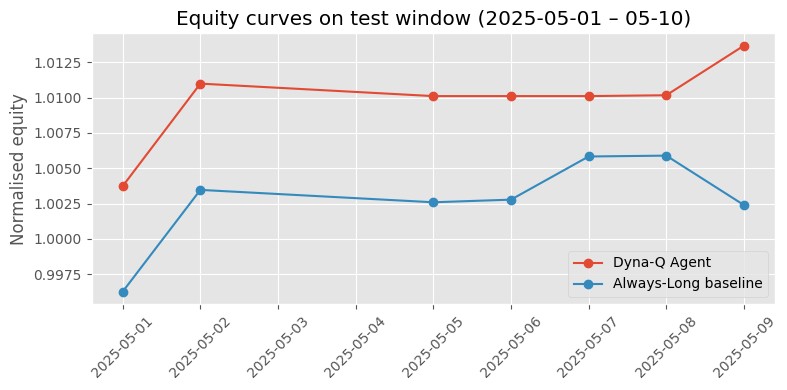

In [40]:

import pandas as pd, numpy as np, random, pickle
import gymnasium as gym
import matplotlib.pyplot as plt
plt.style.use("ggplot")

RET_BINS  = [-0.02, 0, 0.005, 0.01]
POST_BINS = [0.5, 4.5]


posts = pd.read_csv("trump_truths_by_trading_day.csv",
                    parse_dates=["trade_date"])
spx   = pd.read_csv("SPX_20250308_20250510_daily.csv",
                    parse_dates=["Date"]).rename(columns={"Date":"trade_date"})

df = spx.merge(posts, on="trade_date", how="inner").sort_values("trade_date")

train_df = df[df.trade_date <  "2025-05-01"].reset_index(drop=True)
test_df  = df[df.trade_date >= "2025-05-01"].reset_index(drop=True)

print("── Row counts ──")
print("train :", len(train_df), "|", train_df.trade_date.min().date(), "→", train_df.trade_date.max().date())
print("test  :", len(test_df ), "|", test_df.trade_date.min().date(),  "→", test_df.trade_date.max().date())


class SPXDailyEnv(gym.Env):
    def __init__(self, df, ret_bins, post_bins):
        self.df = df.reset_index(drop=True)
        self.ret_bins, self.post_bins = ret_bins, post_bins
        self.n_actions = 3
        self.action_space      = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.MultiDiscrete(
            [len(ret_bins)+1, len(post_bins)+1, 5])
        self._i = 0

    def _state(self, i):
        row = self.df.iloc[i]
        intraday_ret = (row.Close - row.Open) / row.Open
        s_ret  = np.digitize(intraday_ret, self.ret_bins)
        s_post = np.digitize(row.post_count, self.post_bins)
        return (s_ret, s_post, row.trade_date.weekday())

    def reset(self, seed=None, options=None):
        super().reset(seed=seed); self._i = 0
        return self._state(0), {}

    def step(self, action):
        i = self._i; row = self.df.iloc[i]
        intraday_ret = (row.Close - row.Open) / row.Open
        reward = {0:0.0, 1: intraday_ret, 2:-intraday_ret}[action]
        done = (i >= len(self.df)-1)
        if not done: self._i += 1
        return self._state(self._i), reward, done, False, {}


def dyna_q_train(env, episodes=200, alpha=0.1, gamma=0.99,
                 eps_start=1.0, eps_end=0.05, eps_decay=0.95,
                 planning_steps=20):
    Q, model, eps = {}, {}, eps_start
    for _ in range(episodes):
        s,_ = env.reset(); done=False
        while not done:
            a = random.randrange(env.n_actions) if random.random()<eps else np.argmax(Q.get(s, np.zeros(env.n_actions)))
            s2,r,done,_,_ = env.step(a)
            Q.setdefault(s ,np.zeros(env.n_actions))
            Q.setdefault(s2,np.zeros(env.n_actions))
            Q[s][a] += alpha*(r + gamma*np.max(Q[s2]) - Q[s][a])
            model[(s,a)] = (r,s2); s = s2
            for _ in range(planning_steps):
                (ss,aa),(rr,ss2) = random.choice(list(model.items()))
                Q.setdefault(ss ,np.zeros(env.n_actions))
                Q.setdefault(ss2,np.zeros(env.n_actions))
                Q[ss][aa] += alpha*(rr + gamma*np.max(Q[ss2]) - Q[ss][aa])
        eps = max(eps_end, eps*eps_decay)
    return Q

env_train = SPXDailyEnv(train_df, RET_BINS, POST_BINS)
Q = dyna_q_train(env_train); pickle.dump(Q, open("Q_dyna_spx.pkl","wb"))
print("✓ trained Dyna-Q and saved → Q_dyna_spx.pkl")

env_test = SPXDailyEnv(test_df, RET_BINS, POST_BINS)
state,_ = env_test.reset()
agent_equity, rewards, actions = 1.0, [], []
dates = [test_df.trade_date.iloc[0]]

while True:
    a = np.argmax(Q.get(state, np.zeros(env_test.n_actions)))
    ns,r,done,_,_ = env_test.step(a)
    agent_equity *= (1+r); rewards.append(r); actions.append(a)
    dates.append(env_test.df.trade_date.iloc[env_test._i])
    if done: break
    state = ns

# baseline: always long intraday
baseline_r = (test_df.Close - test_df.Open) / test_df.Open
baseline_equity = np.cumprod(1 + baseline_r)

# ── metrics
print("\n── Test metrics (May) ──")
print(f"Agent cum return    : {(agent_equity-1)*100: .2f}%")
print(f"Baseline cum return : {(baseline_equity.iloc[-1]-1)*100: .2f}%")

# Save log
pd.DataFrame({"date":dates[:-1],"action":actions,"reward":rewards,"agent_equity":np.cumprod(1+np.array(rewards))})\
  .to_csv("dyna_q_test_log.csv", index=False)

# ── plot both curves
plt.figure(figsize=(8,4))
plt.plot(dates[:-1], np.cumprod(1+np.array(rewards)), marker='o', label='Dyna-Q Agent')
plt.plot(test_df.trade_date, baseline_equity, marker='o', label='Always-Long baseline')
plt.title("Equity curves on test window (2025-05-01 – 05-10)")
plt.ylabel("Normalised equity")
plt.xticks(rotation=45); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

